Задание ДЗ 2
Обозначения:

p - глубина истории, сколько измерений назад учитываем в моделях

h - горизонт прогноза , на сколько измерений вперед смотрим при моделировании (как далеко предсказываем)

Прочитайте базу "Потребление Энергии" и сделайте модель для сезонных изменений по data_exp_1 с глубиной прогноза h=1 и h=10 по образцу из примера для обработки ряда "цена Нефти" .
Оцените ошибку модели из п.1 .
Сделайте вывод о том, как изменилась ошибка модели по значениям h.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('energy.csv', index_col=[0], parse_dates=[0])

In [3]:
data.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145374 entries, 2002-01-01 to 2018-08-03
Data columns (total 13 columns):
Time               145374 non-null object
PJME_MW            145374 non-null float64
year               145374 non-null int64
month              145374 non-null int64
dayofmonth         145374 non-null int64
quarter            145374 non-null int64
dayofyear          145374 non-null int64
weekofyear         145374 non-null int64
dayofweek          145374 non-null int64
hour               145374 non-null int64
is_holiday         145374 non-null int64
is_prev_holiday    145374 non-null int64
is_next_holiday    145374 non-null int64
dtypes: float64(1), int64(11), object(1)
memory usage: 15.5+ MB


In [5]:
d_data = data['PJME_MW'].values[1:]-data['PJME_MW'].values[:-1]

c:\users\m.biryukov\appdata\local\programs\python\python37\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 't')

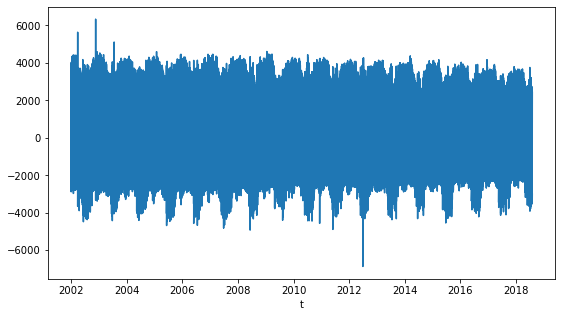

In [6]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(data.iloc[:-1].index,d_data)
plt.xlabel('t')

In [7]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [8]:
data['exp_smoothed'] = exponential_smoothing(data['PJME_MW'], 0.05) # Сгладим экспоненциально

In [14]:
data = data.loc[(data.index >= '2015-01-01') & (data.index < '2016-01-01')] # Ограничимся годом чтобы недолго тренироваться потом

In [16]:
def split_data_b( data, split_date ):
    return data.loc[data.index <= split_date].copy(), data.loc[data.index >  split_date].copy()

train, test = split_data_b(data, '2015-10-10')

In [17]:
from sklearn.ensemble import GradientBoostingRegressor

In [18]:
model_gb = GradientBoostingRegressor(max_depth=15, random_state=0, n_estimators=100)

In [19]:
# Для h = 1

h = 1

X_train = train.iloc[:-h,:]
y_train = train.exp_smoothed.values[h:]
X_test = test.iloc[:-h,:]
y_test = test.exp_smoothed.values[h:]

In [20]:
X_train = X_train.drop(['Time'], axis=1)
X_test = X_test.drop(['Time'], axis=1)

In [21]:
model_gb.fit( X_train, y_train) 

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=15,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto', random_state=0,
                          subsample=1.0, tol=0.0001, validation_fraction=0.1,
                          verbose=0, warm_start=False)

In [23]:
X_test_pred_gb = model_gb.predict(X_test)

In [22]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [30]:
mean_absolute_percentage_error(y_test, X_test_pred_gb)

0.25755459076366294

Вау вау недурно )

In [31]:
# Для h = 10

h = 10

X_train = train.iloc[:-h,:]
y_train = train.exp_smoothed.values[h:]
X_test = test.iloc[:-h,:]
y_test = test.exp_smoothed.values[h:]

In [32]:
X_train = X_train.drop(['Time'], axis=1)
X_test = X_test.drop(['Time'], axis=1)

In [33]:
model_gb.fit( X_train, y_train) 

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=15,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto', random_state=0,
                          subsample=1.0, tol=0.0001, validation_fraction=0.1,
                          verbose=0, warm_start=False)

In [34]:
X_test_pred_gb = model_gb.predict(X_test)

In [35]:
mean_absolute_percentage_error(y_test, X_test_pred_gb)

2.48157490908743

Ошибка при h=10 в 10 раз выше, но все равно не очень высока.

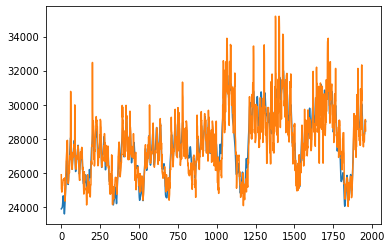

In [36]:
plt.plot(y_test)
plt.plot(X_test_pred_gb)

## Разбросы предсказаний при h=10 очень сильные, особенно вверх

Попробуйте предположить характер ряда (стационарный или нет, с трендом, с сезоном, с циклом) для рядов из списка и аргументируйте свой ответ (одна строка): а) Изменение температуры за окном :).

б) Количество денег, которые тратят покупатели в интернет магазине.

в) Вес растущего котенка.

г) Прирост объема деревьев в лесу от времени

а) Погода за окном (если например поминутные данные за несколько лет) - нестационарный с сезоном и циклом, может и с трендом (глобальное потепление))

б) Количество денег, которые тратят покупатели в интернет магазине - может быть стационарным (если например почасовые данные в рабочий день с 12 до 18), а может нестационарным с сезоном (например, дневные данные магазина кондицинеров)

в) Вес растущего котенка - нестационарный с трендом (особенно если ежедневные данные). Стационарный если поминутные за день )

г) Прирост объема деревьев в лесу от времени - стационарный с трендом, может и сезоном и циклом (если, например деревья больше растут весной и летом)